<a href="https://colab.research.google.com/github/Reut-Maslansky/Sentence-Punctuation-Ariel/blob/master/Sentence_Punctuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import re

### Load the data

Read the wiki file and split the data to list of sentences (in size 30) and each sentence represented by word list 

In [6]:
with open ('/content/drive/MyDrive/Colab Notebooks/heb_wiki.raw', "r") as file:
  dataset=file.read().replace('\n',' ')
  file.close()

In [7]:
dataset=dataset.split(' ')

In [8]:
i=0
data=[]
while i+30<len(dataset):
  if(i>1000000):
   break
  split_sent=[]
  for j in range(i,(i+1)+30):
      split_sent.append(dataset[j])
  i+=10
  data.append(split_sent)
print(data[0])

['מָתֵמָטִיקָה', 'היא', 'תחום', 'הדעת', 'שעוסק', 'במושגים', 'כגון', 'כמות,', 'מבנה,', 'מרחב', 'ושינוי.', 'יש', 'המציגים', 'אותה', 'כמדע', 'של', 'דפוסים', '(תבניות', 'משותפות),', 'וכי', 'המתמטיקאים', 'מחפשים', 'דפוסים:', 'במספרים,', 'במרחב,', 'במדע,', 'במחשבים', 'ובהפשטות', 'דמיוניות.', 'המתמטיקה', 'התפתחה']


Create punctuation map 

In [9]:
punc= {",":"comma",".":"period","?":"question_mark",":":"colon",";":"semicolon","_":"dash","-":"hyphen",")":"right_round_bracket","(":"left_round_bracket","]":"right_square_bracket","[":"left_square_bracket","\\":"slash", "'":"apostrophe","\"":"speech_mark"}

Create words triplets [sentence, word, tag]

In [10]:
sent_taged=[]
for count, sent in enumerate(data, start=1):
  for word in sent:
    tag='O'
    w=word
    if (len(word)>0 and word[0] in punc):
      if (word[-1] in punc):
        tag=punc[str(word[-1])]+" "+punc[str(word[0])]
        w=word[1:-1]
      else:
        tag=punc[str(word[0])]
        w=word[1:]
    elif (len(word)>0 and word[-1] in punc):
      tag=punc[str(word[-1])]
      w=word[:-1]
    sent_taged.append(list([count,w,tag]))
print(sent_taged[0])

[1, 'מָתֵמָטִיקָה', 'O']


Create CSV file from the data

In [11]:
import csv

my_df = pd.DataFrame(sent_taged)
my_df.to_csv('my_csv.csv', index=False, header=False)
data = my_df.fillna(method="ffill")
data.tail(100)

,0,1,2
3099931,99998,בעיית,O
3099932,99998,גטייר,O
3099933,99998,עבור,O
3099934,99998,הגדרת,O
3099935,99998,הידיעה,period
...,...,...,...
3100026,100001,תגובתו,O
3100027,100001,של,O
3100028,100001,אקסטרנליסט,O
3100029,100001,לבעיית,O


In [12]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s[1].values.tolist(),
                                                           s[2].values.tolist())]
        self.grouped = self.data.groupby(0).apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None



Create for each sentence list of words, list of the words tag and list of the sentece tags

In [13]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['מָתֵמָטִיקָה',
 'היא',
 'תחום',
 'הדעת',
 'שעוסק',
 'במושגים',
 'כגון',
 'כמות',
 'מבנה',
 'מרחב',
 'ושינוי',
 'יש',
 'המציגים',
 'אותה',
 'כמדע',
 'של',
 'דפוסים',
 'תבניות',
 'משותפות)',
 'וכי',
 'המתמטיקאים',
 'מחפשים',
 'דפוסים',
 'במספרים',
 'במרחב',
 'במדע',
 'במחשבים',
 'ובהפשטות',
 'דמיוניות',
 'המתמטיקה',
 'התפתחה']

In [14]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'comma', 'comma', 'O', 'period', 'O', 'O', 'O', 'O', 'O', 'O', 'left_round_bracket', 'comma', 'O', 'O', 'O', 'colon', 'comma', 'comma', 'comma', 'O', 'O', 'period', 'O', 'O']


In [15]:
tag_values = list(set(data[2].values))
tag_values.append("PAD")
tag_index = {t: i for i, t in enumerate(tag_values)}

print(tag_index)

{'apostrophe left_square_bracket': 0, 'period left_square_bracket': 1, 'O': 2, 'left_round_bracket': 3, 'comma hyphen': 4, 'apostrophe speech_mark': 5, 'right_round_bracket apostrophe': 6, 'semicolon speech_mark': 7, 'comma colon': 8, 'question_mark speech_mark': 9, 'right_round_bracket right_round_bracket': 10, 'comma period': 11, 'slash': 12, 'right_round_bracket': 13, 'left_square_bracket': 14, 'right_round_bracket speech_mark': 15, 'comma apostrophe': 16, 'semicolon hyphen': 17, 'period question_mark': 18, 'comma': 19, 'period comma': 20, 'comma left_round_bracket': 21, 'period hyphen': 22, 'right_square_bracket right_square_bracket': 23, 'colon period': 24, 'question_mark colon': 25, 'right_square_bracket left_square_bracket': 26, 'period apostrophe': 27, 'apostrophe': 28, 'period period': 29, 'speech_mark left_round_bracket': 30, 'period speech_mark': 31, 'period right_round_bracket': 32, 'hyphen speech_mark': 33, 'comma comma': 34, 'period left_round_bracket': 35, 'apostrophe ap

### Apply Bert

In [16]:
!pip install transformers==2.6.0
!pip install pyplutchik==0.0.7
!pip install transformers==4.14.1
!git clone https://github.com/avichaychriqui/HeBERT.git

     |████████████████████████████████| 540 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 75.5 MB/s 
     |████████████████████████████████| 1.2 MB 68.4 MB/s 
     |████████████████████████████████| 132 kB 65.9 MB/s 
     |████████████████████████████████| 5.6 MB 23.1 MB/s 
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 8.6 MB 64.6 MB/s 
     |████████████████████████████████| 138 kB 71.4 MB/s 
     |████████████████████████████████| 127 kB 95.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 53.0 MB/s 
     |████████████████████████████████| 596 kB 67.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2
  Attempting uninstall: transformers
    Found existing installation: transformers 2.6.0
    Uninstalling transformers-2.6.0:
      Successfully uninstalled transformers-2.6.0
Cloning into 'HeBERT'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 241 (delta 86), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (241/241), 2.24 MiB | 4.06

In [17]:
!pip install awscli --ignore-installed six

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
  Using cached botocore-1.24.27-py3-none-any.whl (8.6 MB)
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)
     |████████████████████████████████| 547 kB 71.4 MB/s 
     |████████████████████████████████| 636 kB 88.0 MB/s 
  Using cached jmespath-1.0.0-py3-none-any.whl (23 kB)
     |████████████████████████████████| 247 kB 93.6 MB/s 
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
     |████████████████████████████████| 77 kB 7.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascienc

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper

In [19]:
MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

The AlephBert implementation comes with a pretrained tokenizer and a definied vocabulary.

We load 'alephbert-base' becuase it is well suited for NER.  



In [20]:
import pickle
from transformers import BertModel, BertTokenizerFast,BertForMaskedLM
from transformers import AdamW, BertForTokenClassification
tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')

Downloading:   0%|          | 0.00/532k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens. We have to deal with the issue of splitting our token-level labels to related subtokens.

In [21]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [22]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [23]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [24]:
print (tokenized_texts[0])

['מתמטיקה', 'היא', 'תחום', 'הדעת', 'שעוסק', 'במושגים', 'כגון', 'כמות', 'מבנה', 'מרחב', 'ושינוי', 'יש', 'המציגים', 'אותה', 'כמד', '##ע', 'של', 'דפוסים', 'תבניות', 'משותפות', ')', 'וכי', 'המת', '##מטיקאי', '##ם', 'מחפשים', 'דפוסים', 'במספרים', 'במרחב', 'במדע', 'במחשבים', 'ובה', '##פשטות', 'דמיוני', '##ות', 'המתמטיקה', 'התפתחה']


In [25]:
print (labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'comma', 'comma', 'O', 'period', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'left_round_bracket', 'comma', 'comma', 'O', 'O', 'O', 'O', 'O', 'colon', 'comma', 'comma', 'comma', 'O', 'O', 'O', 'period', 'period', 'O', 'O']


Cut and pad the token and label sequences to our desired length.

In [26]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [27]:
tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

The Bert model supports something called attention_mask, which is similar to the masking in keras. 

So here we create the mask to ignore the padded elements in the sequences.

In [28]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

Split the dataset to use 10% to validate the model.

In [29]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

 Convert the dataset to torch tensors

In [30]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

define the dataloaders- shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [31]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

### Setup the AlephBERT model for finetuning

Load the pre-trained model and provide the number of possible labels.

In [32]:
alephbert = BertForTokenClassification.from_pretrained(
    'onlplab/alephbert-base',
    num_labels=len(tag_index),
    output_attentions = False,
    output_hidden_states = False
    )

Downloading:   0%|          | 0.00/481M [00:00<?, ?B/s]

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are new

Pass the model parameters to the GPU.

In [33]:
alephbert.cuda();

Setup the optimizer and add the parameters it should update.

In [34]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(alephbert.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(alephbert.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(alephbert.parameters(), lr=1e-5)

Add a scheduler to linearly reduce the learning rate throughout the epochs.

In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

###Fit BERT for named entity recognition

Define some metrics to track while training.

In [36]:
! pip install seqeval

     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=57d96c863ad90061dc95cc85a449e3425ccafd8fb02582d5c77f3d4706af5111
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [37]:
from seqeval.metrics import f1_score, accuracy_score

Finetune the model

In [38]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
for _ in trange(epochs, desc="Epoch"):
    # Put the model into training mode.
    alephbert.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = alephbert(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=alephbert.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    alephbert.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = alephbert(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.3871904545795693
Validation loss: 0.29040176709429527
Validation Accuracy: 0.9060922522043118



Epoch:  33%|███▎      | 1/3 [13:17<26:35, 797.95s/it]

Average train loss: 0.2755295188718108
Validation loss: 0.2589244592113617
Validation Accuracy: 0.9150129708875635



Epoch:  67%|██████▋   | 2/3 [26:35<13:17, 797.79s/it]

Average train loss: 0.24497201978376315
Validation loss: 0.24995961704383643
Validation Accuracy: 0.9179742257501066



Epoch: 100%|██████████| 3/3 [39:53<00:00, 797.77s/it]


In [47]:
torch.save(alephbert, "/content/drive/MyDrive/Colab Notebooks/punctuation_model.pth")

In [48]:
torch.save(tokenizer, "/content/drive/MyDrive/Colab Notebooks/tokenizer.pth")

###Visualize the training loss


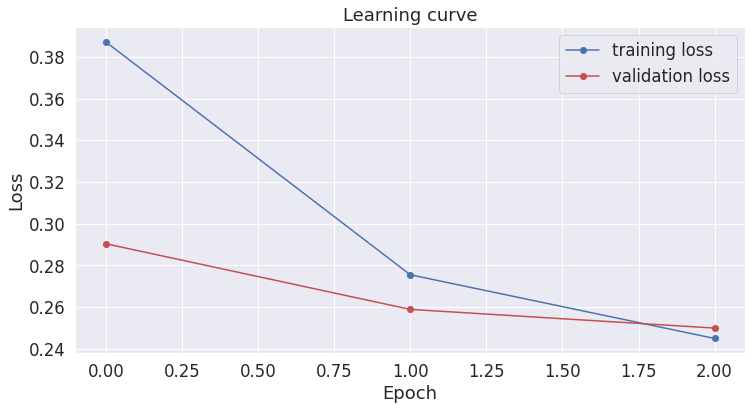

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

###Apply the model to a new sentence

In [40]:
test_sentence = "בית ספר הוא מוסד חינוכי בבעלות פרטית או ממשלתית האחראי על פרק הלימוד הטרום אקדמי על פי רוב בית ספר הוא מבנה בו משתתפים תלמידים וסגל הוראה בשיעורים יומיים מנהל בית ספר אחראי בדרך כלל גם על ניהול פיזי וכלכלי של בית הספר וגם על הנהגתו החינוכית עם זאת ניתן למצוא לעיתים לצידו של המנהל החינוכי יועצים חינוכיים המסייעים לתלמידים לפתור בעיות שונות העלולות לפגוע בתפקוד האקדמי שלהם"

test_sentence_punc=".בית ספר הוא מוסד חינוכי בבעלות פרטית או ממשלתית, האחראי על פרק הלימוד הטרום־אקדמי. על פי רוב, בית ספר הוא מבנה בו משתתפים תלמידים וסגל הוראה בשיעורים יומיים. מנהל בית ספר אחראי בדרך כלל גם על ניהול פיזי וכלכלי של בית הספר וגם על הנהגתו החינוכית. עם זאת, ניתן למצוא לעיתים לצידו של המנהל החינוכי יועצים חינוכיים, המסייעים לתלמידים לפתור בעיות שונות העלולות לפגוע בתפקוד האקדמי שלהם"

#test_sentence ="שנים רבות חשבו בני האדם שבעלי חיים מסוימים כמו הגירף העטלף והלווייתן הם אילמים כלומר אינם מסוגלים להשמיע קול בני האדם חשבו כך משום שהם לא היו מסוגלים לשמוע את קולות בעלי החיים האלה חוקרי טבע שהיו סקרנים לדעת מדוע לבעלי חיים אילמים יש פה ואוזניים ואיך הם מתקשרים זה עם זה ללא קול החלו לחקור את בעלי החיים האלה כדי למצוא תשובות לשאלותיהם ככל שהתפתחו והשתכללו המכשירים להקלטת צלילים כך התגלו דברים מפתיעים בנוגע לקולות בעלי החיים ולתקשורת ביניהם"

#test_sentence_punc=".שנים רבות חשבו בני האדם שבעלי חיים מסוימים, כמו הג'ירף, העטלף והלווייתן, הם אילמים, כלומר אינם מסוגלים להשמיע קול. בני האדם חשבו כך משום שהם לא היו מסוגלים לשמוע את קולות בעלי החיים האלה. חוקרי טבע שהיו סקרנים לדעת מדוע לבעלי חיים \"אילמים\" יש פה ואוזניים ואיך הם מתקשרים זה עם זה ללא קול, החלו לחקור את בעלי החיים האלה כדי למצוא תשובות לשאלותיהם. ככל שהתפתחו והשתכללו המכשירים להקלטת צלילים, כך התגלו דברים מפתיעים בנוגע לקולות בעלי החיים ולתקשורת ביניהם"

Tokenize the text.

In [41]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

Run the sentence through the model.

In [42]:
with torch.no_grad():
    output = alephbert(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [43]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [44]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	בית
O	ספר
O	הוא
O	מוסד
O	חינוכי
O	בבעלות
O	פרטית
O	או
comma	ממשלתית
O	האחראי
O	על
O	פרק
O	הלימוד
O	הטרום
period	אקדמי
O	על
O	פי
comma	רוב
O	בית
O	ספר
O	הוא
O	מבנה
O	בו
O	משתתפים
O	תלמידים
O	וסגל
O	הוראה
O	בשיעורים
period	יומיים
O	מנהל
O	בית
O	ספר
O	אחראי
O	בדרך
O	כלל
O	גם
O	על
O	ניהול
O	פיזי
O	וכלכלי
O	של
O	בית
O	הספר
O	וגם
O	על
O	הנהגתו
period	החינוכית
O	עם
comma	זאת
O	ניתן
O	למצוא
O	לעיתים
O	לצידו
O	של
O	המנהל
O	החינוכי
O	יועצים
O	חינוכיים
O	המסייעים
O	לתלמידים
O	לפתור
O	בעיות
O	שונות
O	העלולות
O	לפגוע
O	בתפקוד
O	האקדמי
period	שלהם
O	[SEP]


In [45]:
result=""
val_list = list(punc.values())
key_list = list(punc.keys())
for token, label in zip(new_tokens, new_labels):
  result= result+token 
  if(label!='O'):
    result=result+key_list[val_list.index(label)]
  result=result+" "
print(result)

[CLS] בית ספר הוא מוסד חינוכי בבעלות פרטית או ממשלתית, האחראי על פרק הלימוד הטרום אקדמי. על פי רוב, בית ספר הוא מבנה בו משתתפים תלמידים וסגל הוראה בשיעורים יומיים. מנהל בית ספר אחראי בדרך כלל גם על ניהול פיזי וכלכלי של בית הספר וגם על הנהגתו החינוכית. עם זאת, ניתן למצוא לעיתים לצידו של המנהל החינוכי יועצים חינוכיים המסייעים לתלמידים לפתור בעיות שונות העלולות לפגוע בתפקוד האקדמי שלהם. [SEP] 


In [46]:
print(test_sentence_punc)

.בית ספר הוא מוסד חינוכי בבעלות פרטית או ממשלתית, האחראי על פרק הלימוד הטרום־אקדמי. על פי רוב, בית ספר הוא מבנה בו משתתפים תלמידים וסגל הוראה בשיעורים יומיים. מנהל בית ספר אחראי בדרך כלל גם על ניהול פיזי וכלכלי של בית הספר וגם על הנהגתו החינוכית. עם זאת, ניתן למצוא לעיתים לצידו של המנהל החינוכי יועצים חינוכיים, המסייעים לתלמידים לפתור בעיות שונות העלולות לפגוע בתפקוד האקדמי שלהם
